<center>
<img src =data/images/hello.gif width = 500 />
</center>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

In [2]:
precip = pd.read_table("data/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30


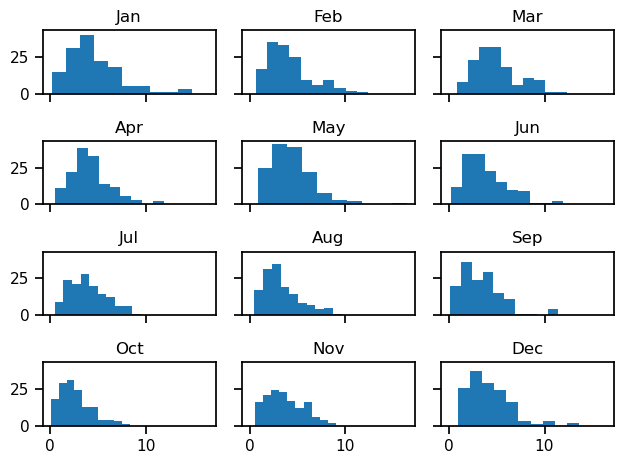

In [3]:
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

In [4]:
precip.fillna(value={'Apr': precip.Apr.mean()}, inplace=True)
# precip

In [5]:
precip_mean = precip.mean()
# precip_mean

In [6]:
precip_var = precip.var()
# precip_var

In [7]:
precip.Apr

Year
1871     4.13
1872     5.91
1873     3.59
1874    11.84
1875     4.22
        ...  
2007     2.75
2008     7.20
2009     4.13
2010     3.48
2011     7.51
Name: Apr, Length: 141, dtype: float64

<Axes: >

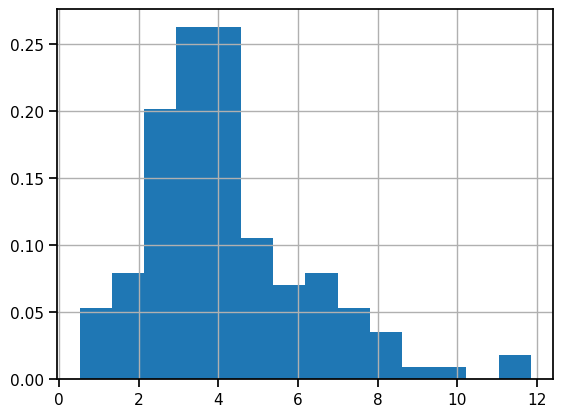

In [8]:
precip.Apr.hist(density=True, bins='auto')

In [11]:
# pip install --upgrade pymc

In [13]:
# pip install --upgrade pytensor

In [9]:
import pymc as pm

with pm.Model() as rainfall_model:
    # Define priors for the alpha and beta parameters of the Gamma distribution
    ualpha = pm.Uniform('ualpha', lower=0, upper=15)
    ubeta = pm.Uniform('ubeta', lower=0, upper=15)
    
    # Gamma distribution for April rainfall
    april_like = pm.Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)


In [10]:
import pymc as pm

with rainfall_model: 
    rainfall_trace = pm.sample(1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [25]:
# print(rainfall_trace.posterior)

In [11]:
# Calculate the posterior means
ualpha_posterior_mean = rainfall_trace.posterior['ualpha'].mean().values
ubeta_posterior_mean = rainfall_trace.posterior['ubeta'].mean().values

# Print the means
print('ualpha_posterior_mean:', ualpha_posterior_mean)
print('ubeta_posterior_mean:', ubeta_posterior_mean)

ualpha_posterior_mean: 4.355519157672046
ubeta_posterior_mean: 1.036510420559012


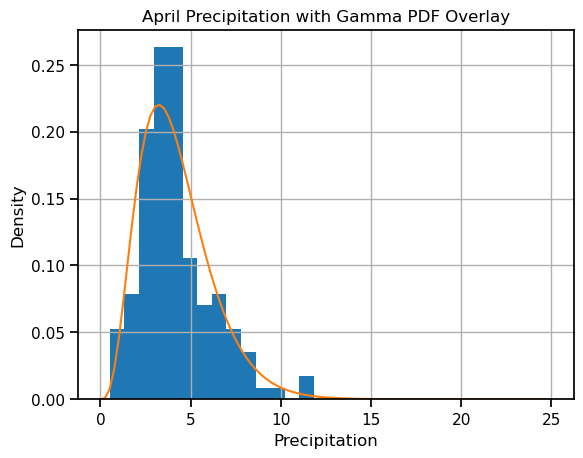

In [12]:
from scipy.stats.distributions import gamma

precip.Apr.hist(density=True, bins='auto')

# Generating data for the gamma PDF
x = np.linspace(0, 25, 100)
y = gamma.pdf(x, a=ualpha_posterior_mean, scale=1/ubeta_posterior_mean)

# Plotting the gamma PDF
plt.plot(x, y)

# Optional: Add labels and title for clarity
plt.xlabel('Precipitation')
plt.ylabel('Density')
plt.title('April Precipitation with Gamma PDF Overlay')

# Show the plot
plt.show()

<center>
    <h2>It's Bayesian Time</h2>
    <img src="data/images/bayesian.gif" width="500" />
</center>


#### KS Test for each month's model #
We performed KS test on each months model, comparing our model which originated from the Bayesian estimation approach to the theoretical sampling from the Gamma distribution. The resulting p values for each month were really high which suggests that our models were a good fit for every single month.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
from scipy.stats import gamma, ks_2samp

In [19]:
def analyze_precipitation_by_month(precip, month, ax, random_seed=123):
    # Check if the month column has at least one non-null value
    if precip[month].notna().sum() == 0:
        ax.set_title(f"No data for {month}")
        return None, None

    # Data preprocessing: Fill NA values with the month's mean
    precip.fillna(value={month: precip[month].mean()}, inplace=True)

    with pm.Model() as rainfall_model:
        # Define priors
        ualpha = pm.Uniform('ualpha', lower=0, upper=15)
        ubeta = pm.Uniform('ubeta', lower=0, upper=15)
        
        # Gamma distribution for the month's rainfall
        monthly_like = pm.Gamma('monthly_like', alpha=ualpha, beta=ubeta, observed=precip[month])

        # Sampling from the posterior
        rainfall_trace = pm.sample(1000, random_seed=random_seed)

    # Posterior means
    ualpha_posterior_mean = rainfall_trace.posterior['ualpha'].mean().values
    ubeta_posterior_mean = rainfall_trace.posterior['ubeta'].mean().values

    # Plotting the histogram
    precip[month].hist(density=True, bins='auto', ax=ax)

    # Gamma PDF
    x = np.linspace(0, 25, 100)
    y = gamma.pdf(x, a=ualpha_posterior_mean, scale=1/ubeta_posterior_mean)
    ax.plot(x, y, color='red')

    # Title
    ax.set_title(f'{month} Precipitation')
    
    # KS Test
    gamma_samples = gamma.rvs(a=ualpha_posterior_mean, scale=1/ubeta_posterior_mean, size=10000)
    ks_stat, p_value = ks_2samp(precip[month].dropna(), gamma_samples)

    # Plotting the gamma PDF on the same axis
    ax.plot(x, y, color='red')

    # Set title for each subplot
    ax.set_title(f'{month} Precipitation')

    # Annotate with KS Test results
    ax.text(0.95, 0.95, f'KS Stat: {ks_stat:.2f}, P-value: {p_value:.2e}', 
            horizontalalignment='right', verticalalignment='top', 
            transform=ax.transAxes, fontsize=10, color='blue')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ualpha, ubeta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


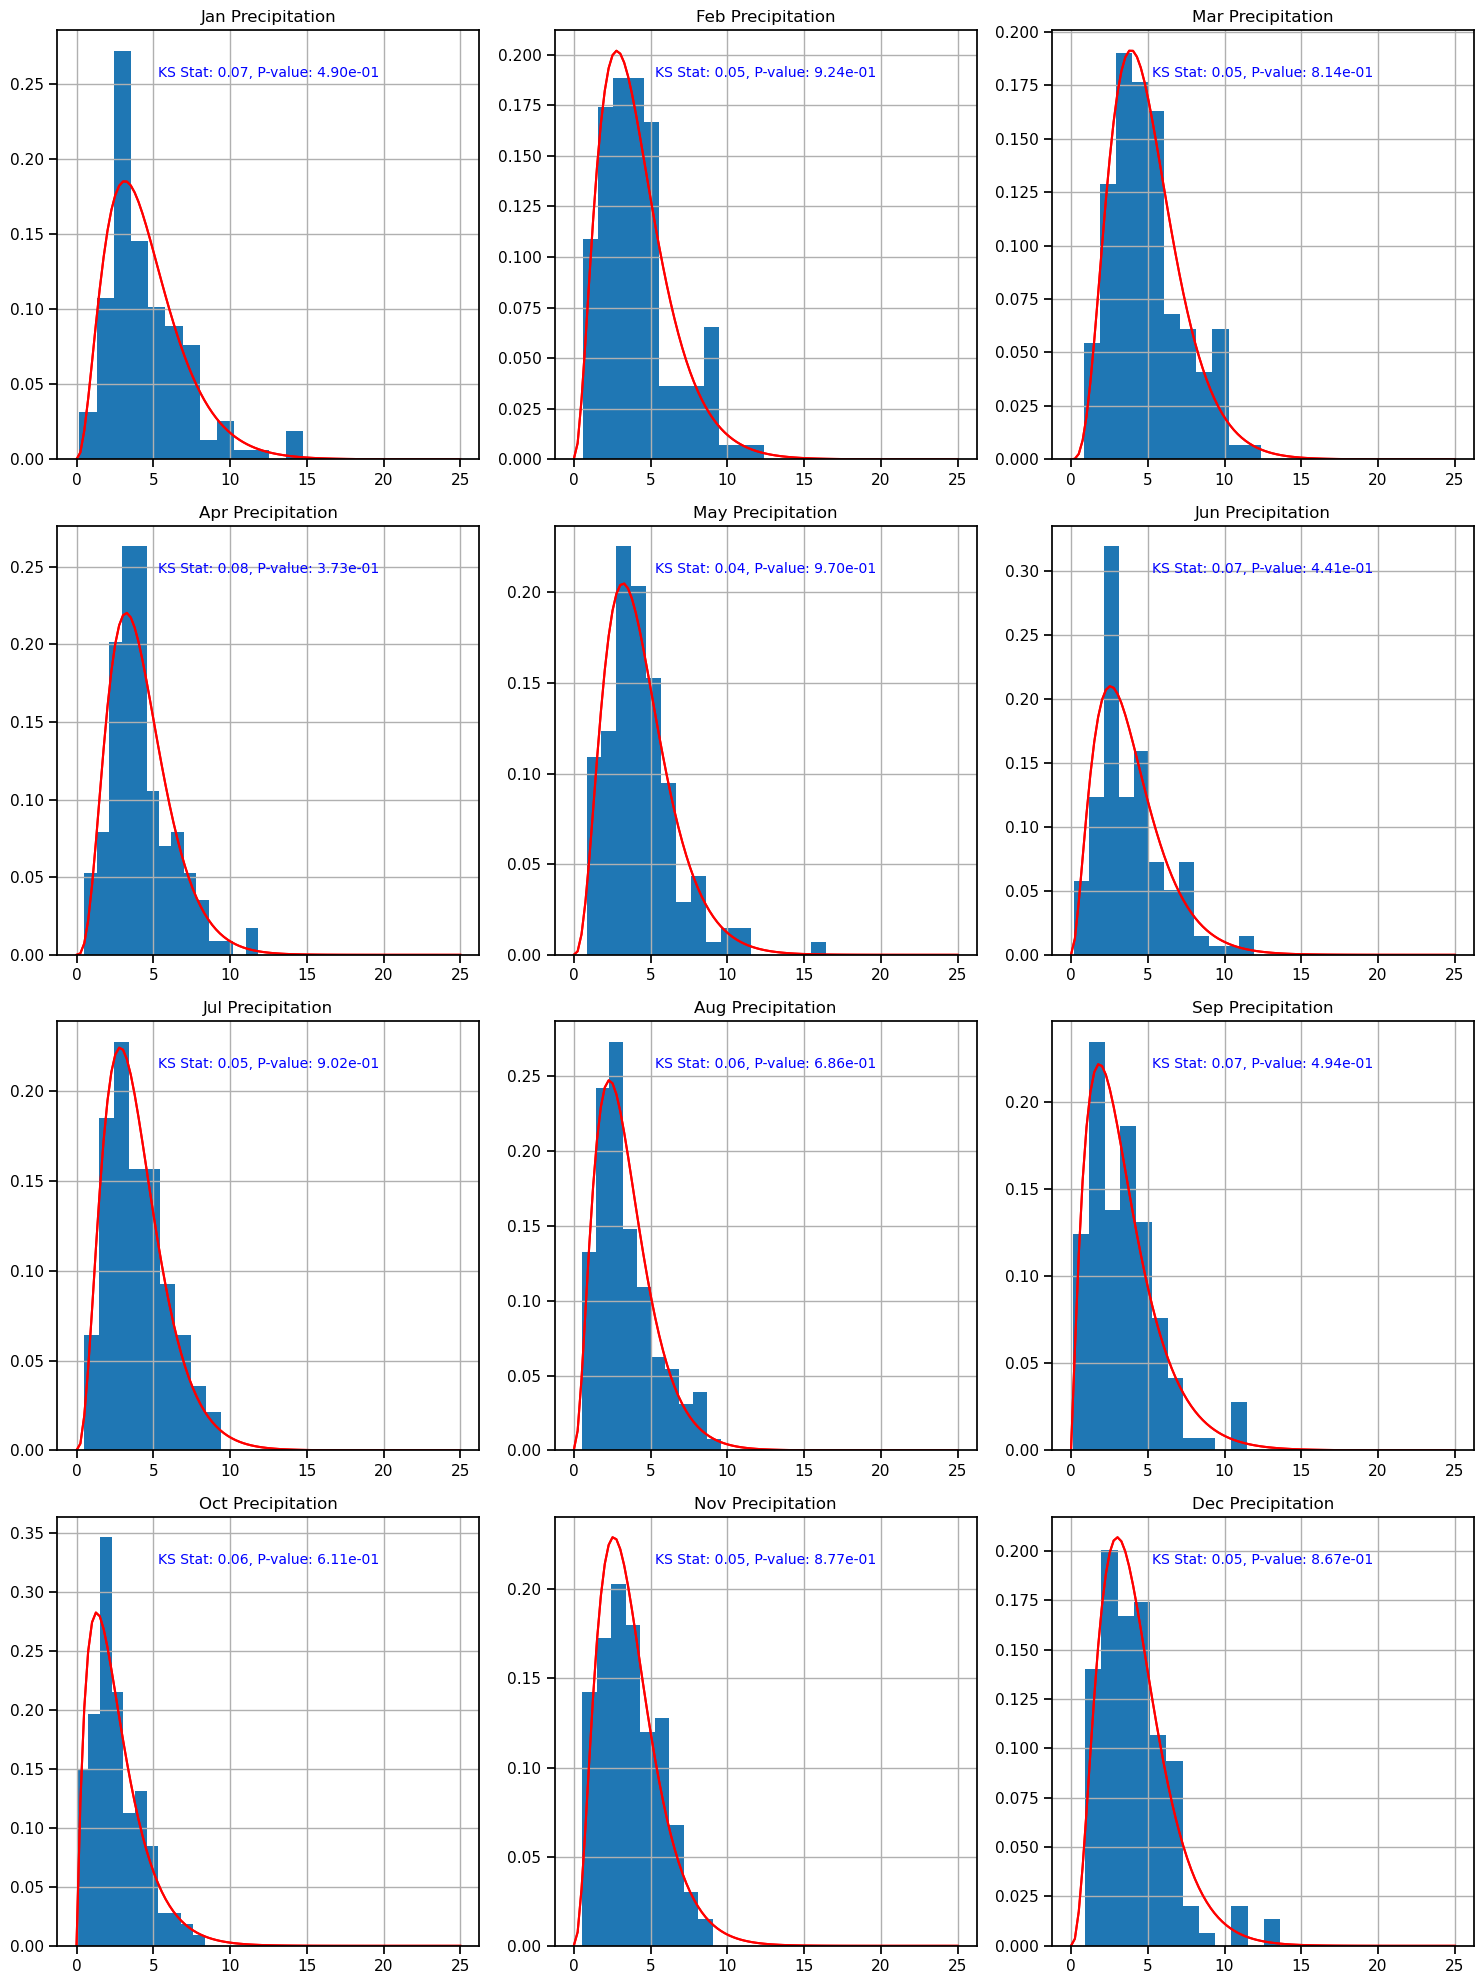

In [20]:
# Setting up the figure for subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))

# Analyzing precipitation for each month and plotting
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month, ax in zip(months, axes.flatten()):
    analyze_precipitation_by_month(precip, month, ax)

# Adjust layout
plt.tight_layout()
plt.show()

<center>
    <h2>Importance of the KS Test</h2>
    <img src =data/images/ks_testtt.webp width = 500 />
</center>

The Kolmogorov-Smirnov (KS) test is a nonparametric test used to determine whether two datasets differ significantly. In your case, it compares the observed precipitation data for a given month with a set of samples drawn from the theoretical Gamma distribution that your model assumes the data follows.

- **KS Statistic**: Measures the maximum difference between the empirical cumulative distribution function (CDF) of your observed data and the CDF of the theoretical Gamma distribution.
- **P-value**: Indicates the probability of observing a KS statistic as extreme as the one calculated, under the assumption that the observed data actually follows the theoretical distribution.
  - A **high P-value** (typically greater than 0.05) suggests that the observed data does not significantly differ from the theoretical Gamma distribution, indicating a good fit. 
  - Conversely, a **low P-value** indicates a significant difference, suggesting that the Gamma distribution may not be a good fit for the observed data.
- A **small KS statistic** suggests that the sample distribution closely matches the theoretical distribution.


#### Get latest data here
https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00013897/detail

<center>
<img src =data/images/byyeeee.gif width = 500 />
</center>